# LightGBM Using Serverless Functions

```mlrun``` is an open-source Python package that provides a framework for running machine learning tasks transparently in multiple, scalable, runtime environments.  ```mlrun``` provides tracking of code, metadata, inputs, outputs and the results of machine learning pipelines. 

In this notebook we'll take a look at using ```mlrun```, ```nuclio``` and KubeFlow to assemble a model training pipeline and deploy it as a nuclio serverless function with an API endpoint for testing.  The focus here is on how all the components interact, and less on the boosting model and its optimization for the Higgs dataset.

# Setup

The following are some dependencies that must be installed before working with this notebook. They only need to be run once.

The first is a snippet that creates a subfolder ```data``` and downloads the raw data file.  You can also try the alternative routine in the notebook **[acquire higgs-data](#acquire-higgs-data.ipynb)**.

In [1]:
# %%sh
# mkdir data
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz -O data/HIGGS.csv.gz

The following will reinstall the latest development version of ```mlrun```:

In [2]:
# !pip uninstall -y mlrun
# !pip install git+https://github.com/mlrun/mlrun.git@development

Install the KubeFlow pipelines package ```kfp```. For more information see the **[KubeFlow documentation on nuclio](https://www.kubeflow.org/docs/components/misc/nuclio/)** and  **[Kubeflow pipelines and nuclio](https://github.com/kubeflow/pipelines/tree/master/components/nuclio)**. For logging the estimated machine learning models we'll use ```joblib```'s [```dump``` and ```load```](https://joblib.readthedocs.io/en/latest/persistence.html#persistence).

In [3]:
# !pip install -U kfp joblib

# **nuclio code section**

#### nuclio's _**ignore**_ notation

Between the tags ```# nuclio: ignore```, meaning ignore all the code here and above, and ```# nuclio: end-code```, meaning ignore everything after this annotation, you'll write all the code that gets packaged for execution.  Methods in this code section can be called separately if designed as such (```load```, ```train```, ```test```), or as you'll discover below, they are most often "chained" together to form a pipeline where the output of one stage serves as the input to the next. The **[docs](https://github.com/nuclio/nuclio-jupyter#creating-and-debugging-functions-using-nuclio-magic)** also suggest another approach: 
> if we want to ignore many cells at the beginning of the notebook (e.g. data exploration and model training) we can use ```# nuclio: start``` at the first relevant code cell instead of marking all the cells above with ```# nuclio: ignore```.

See the **[nuclio-jupyter](https://github.com/nuclio/nuclio-jupyter)** repo for further information on these and many other **[nuclio magic commands](https://github.com/nuclio/nuclio-jupyter#creating-and-debugging-functions-using-nuclio-magic)** that make it easy to transform the Jupyter notebook environment into a platform for developing production-quality, machine learning systems.

The ```nuclio-jupyter``` package provides methods for automatically generating and deploying nuclio serverless functions from code, repositories or Jupyter notebooks. **_If you have never run nuclio functions in your notebooks, please uncomment and run the following_**: ```!pip install nuclio-jupyter```

The following two lines mark the start of you ML code definition, and they should be in the same cell:

In [4]:
# nuclio: ignore
import nuclio 

The installs made in the section **[Setup](#Setup)** covered the Jupyter environment within which this notebook runs.  However, we need to ensure that all the dependencies our nuclio function relies upon (such as matplotlib or scikit-learn), will be available when that code is wrapped up into a nuclio function _**on some presently unknown runtime**_.   Within the nuclio code section we can ensure these dependencies get built into the function with the ```%nuclio cmd``` magic command.

In [5]:
### Define function dependencies
%nuclio cmd -c pip install -U matplotlib sklearn lightgbm kfp joblib pyarrow

We'll use a standard base image here, however the build step can be shortened by preparing images with pre-installed packages.

In [6]:
%nuclio config spec.build.baseImage = "python:3.6-jessie"

%nuclio: setting spec.build.baseImage to 'python:3.6-jessie'


In [7]:
from os import path, makedirs
import joblib
from io import StringIO, BytesIO
from urllib.request import urlretrieve

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split

import lightgbm as lgb
import pyarrow.parquet as pq
import pyarrow as pa
import pandas as pd
from mlrun.artifacts import ChartArtifact, TableArtifact, PlotArtifact

In [8]:
import warnings
warnings.filterwarnings('ignore')

### Utilitiy Functions



In [9]:
def get_context_table(ctxtable):
    """Get table from context.
    
    Convenience function to retrieve a table via a blob.
    
    Args:
        ctxtable (mlrun.datastore.DataItem) : The table saved in the context, 
            which needs to be deserialized.
        
    In this demonstration tables are stored in parquet format and passed
    between steps as blobs.  We could also pass folder or file names
    in the context, which may be faster.
    """
    blob = BytesIO(ctxtable.get())
    return pd.read_parquet(blob, engine='pyarrow')

In [10]:
def log_context_table(context, target, name, table):
    """Log a table through the context.
    
    The table is written as a parquet file.  
    
    NOT SURE WHAT IS GETTING LOGGED AND THE TIME IT IS TAKING.
    
    Args:
        context (mlrun.execution.MLClientCtx) : The `context`.
        target (str) : Location (folder) of our DataItem.
        name (str) : Name of the object in the context.
        table ()
    """
    context.logger.info(f'writing {name}')
    pq.write_table(
        pa.Table.from_pandas(table),
        path.join(target, name))    
    context.log_artifact(name, target_path=path.join(target, name))

### load

In the first step we load the original data, generate labels and split into train-validation-test sets. The split tables are saved and logged.

In another project, this step may involve all of the data preprocessing steps like cleaning, resizing and augmenting images, prefiltering, etc...

In [11]:
def load(context,
         target='',
         src='original',
         splits=[0.9, 0.75],
         random_state=1,
         sample=-1
):
    """Load raw data artifacts.
    
    The file loaded at this stage is the raw data file that has been
    downloaded in a previous step.  Here it is read and split
    into train, validation and test sets, and these are stored at
    the `target_path` as parquet files using the function `log_context_table`. 
    They are logged in the context (NOT SURE HOW, AS PATHS, AS FILES, 
    SERIALIZED...).
    
    Args:
        context (mlrun.execution.MLClientCtx) : The `context`.
        target (str) : Data storage location.
        src (str) : Location of original dta parquet file.
        splits (array-like) : 2 floats, defaults to (0.9, 0.75), giving a test
            set of 10%, training of 0.9x0.75=67.5%, and the remainder in 
            the validation set.
        random_state (int) : Seed used by scikit-learn random
            number generator in train_test_split.
        sample (int) : (default -1, all rows). Selects the first n rows, or
            select a sample. Check the balance of resulting sets if
            using the random sample option. Use this feature to explore the
            system or for debugging.
    """
    
    filepath = path.join(target, src)
    context.logger.info(f'reading original {filepath}')
    
    # save only a sample, intended for debugging
    if (sample == -1) or (sample > 0):
        # either all or sample first rows
        original = pq.read_table(filepath).to_pandas()
        labels = original.pop('labels')
        original = original.iloc[:sample, :]
        labels = labels.iloc[:sample]
    elif sample < 0:
        # grab a random sample, usually use this
        original = pq.read_table(path.join(target, src)
                                ).to_pandas().sample(sample*-1)
        labels = original.pop('labels')
    else:
        raise Exception("can't do much with 0 rows!, set sample to some \
            negative or positive number")
    
    context.logger.info(f'input {original.shape[0]} rows')
    
    # split twice to get training, validation and test sets, not an ideal
    # approach. Better to use numpy randomint, and use it to partition
    # the original data set and index the tables (not implemented here).
    context.logger.info('splitting into train-valid-test data sets')
    x, xtest, y, ytest = train_test_split(original, 
                                          labels, 
                                          train_size=splits[0], 
                                          test_size=1-splits[0], 
                                          random_state=random_state)
    
    xtrain, xvalid, ytrain, yvalid = train_test_split(x, 
                                                      y, 
                                                      train_size=splits[1], 
                                                      test_size=1-splits[1],
                                                      random_state=random_state)    

    log_context_table(context, target, 'xtrain', xtrain)
    log_context_table(context, target, 'xvalid', xvalid)
    log_context_table(context, target, 'xtest', xtest)
    log_context_table(context, target, 'ytrain', pd.DataFrame({'labels':ytrain}))
    log_context_table(context, target, 'yvalid', pd.DataFrame({'labels':yvalid}))
    log_context_table(context, target, 'ytest', pd.DataFrame({'labels':ytest}))

### training   
We have used only 2 parameters for demonstration purposes, ```learning_rate``` and ```num_leaves```, see **[LightGBM Parameters](https://lightgbm.readthedocs.io/en/latest/Parameters.html#parameters)** for
more detail on the other parameters available and their default values.


In [12]:
def train(context,
          xtrain,
          ytrain,
          xvalid,
          yvalid,
          silent=False,
          random_state=1,
          model_target='',
          model_name='model.NOGOOD.pickle',
          num_leaves=31,  # randomly selected paramers to search over....
          learning_rate= 0.1,
    ):
    """Train and save a LightGBM model.
    
    Args:
        context (mlrun.execution.MLClientCtx) : The function's context.
        xtrain (mlrun.datastore.DataItem) : DataItem in context
            representing 2D array (obs, features)  of features. 
        ytrain (mlrun.datastore.DataItem) : DataItem in the
            context representing ground-truth labels.
        xvalid, yvalid are a similarly defined validation set.
        silent (bool) : (default False) Show metrics for 
            training/validation steps.
        random_state (int/RandomState/None) : As int, a seed, as 
            RandomState a scikit learn state instance, or use
            numpy's RandomState if set to None.
        model_target (str) : Destination path for model artifact.
        model_name (str) : Destination name for model artifact.
        
        Also included for demonstration are a randomly selected 
        sample of LightGBM parameters.
    """
    lgb_clf = lgb.LGBMClassifier(num_leaves=num_leaves,
                                 learning_rate= learning_rate,
                                 objective='binary',
                                 metric='binary_logloss',
                                 random_state=random_state,
                                 silent=not silent)

    context.logger.info('read tables')
    xtrain = get_context_table(xtrain)
    ytrain = get_context_table(ytrain)
    xvalid = get_context_table(xvalid)
    yvalid = get_context_table(yvalid)
    
    context.logger.info(f'training input {xtrain.shape[0]} rows')
    context.logger.info('starting train')
    lgb_clf.fit(xtrain, 
               ytrain,
               eval_set=[(xvalid, yvalid), (xtrain, ytrain)],
               eval_names=['valid', 'train'],
               verbose=silent)
    
    # pickle/serialize the model at target
    if not path.isdir(model_target):
        makedirs(model_target)
    file_path = path.join(model_target, model_name)
    joblib.dump(lgb_clf, open(file_path, 'wb'))
    context.log_artifact('model',
                         target_path=model_target,
                         labels={'framework': 'xgboost'})

### testing

In addition to a ```model```, the last step created test features and labels we pass on to the ```test()``` method.  An ROC plot is built using the test set and make it available for display.

In [13]:
def plot_roc(ytest, ypred, fmt="png"):
    """Plot an ROC curve.
    
    Args:
        ytest (array-like) : Ground-truth labels.
        ypred (array-like) : Predictions given a test sample and 
            an estimated model.
        fmt (str) : The file image format (png, jpg, ...), and 
            the saved file extension.
    """
    fpr_xg, tpr_xg, _ = roc_curve(ytest, ypred)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_xg, tpr_xg, label='xgboost')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('roc curve - lightgbm')
    plt.legend(loc='best')
    return plt.gcf()    

In [34]:
def test(context, model, xtest, ytest, fmt='png', model_target='', model_name='lightgbm.model.pickle'):
    """Load model and predict.
    
    Arg:
        context (mlrun.execution.MLClientCtx) : The `context`.
        model (mlrun.datastore.DataItem) : 
        xtest (array-like) : (NxM), N is sample size and M the number of features
            of the test set.
        ytest (array-like) : 1D (N,1) Array of ground-truth labels,
        fmt (str) : The image format (default is 'png').
        target_path (str) : 
        
    """
    filepath = path.join(str(model), model_name)
    context.logger.info(filepath)
    lgbm_model = joblib.load(
        open(filepath, 'rb'))
    
    xtest = get_context_table(xtest)
    ytest = get_context_table(ytest)
    context.logger.info(f'test input {xtest.shape[0]} rows')
    
    ypred = lgbm_model.predict(xtest)
    
    acc = accuracy_score(ytest, ypred)
    context.logger.info(f'type: {type(acc)}   value: {acc}')
    context.log_result('accuracy', float(acc))
    
    fig = plot_roc(ytest, ypred, fmt)

    context.log_artifact(PlotArtifact('roc-curve', body=fig))    

#### **end of nuclio function definition**

In [15]:
# nuclio: end-code

# **mlrun code**

In [16]:
from mlrun import code_to_function, mount_v3io, new_function, new_model_server, mlconf
# for local DB path use 'User/mlrun' instead 
%env MLRUN_DBPATH=/User/mlrun
mlconf.dbpath = '/User/mlrun'

env: MLRUN_DBPATH=/User/mlrun


# Debug section

The function can be run locally and debugged/tested before deployment:

In [17]:
workflow = new_function()

load_run = workflow.run(
    name='load_and_preprocess',
    handler=load, 
    params={
        'sample': -2_000,
        'target': '/User/projects/lightgbm/data/raw'})

[mlrun] 2019-12-15 12:08:00,569 starting run load_and_preprocess uid=7379b4a0d52a451fa91a9430b2b015f9  -> /User/mlrun
[mlrun] 2019-12-15 12:08:00,793 reading original /User/projects/lightgbm/data/raw/original
[mlrun] 2019-12-15 12:08:03,801 input 2000 rows
[mlrun] 2019-12-15 12:08:03,802 splitting into train-valid-test data sets
[mlrun] 2019-12-15 12:08:03,805 writing xtrain
[mlrun] 2019-12-15 12:08:03,868 writing xvalid
[mlrun] 2019-12-15 12:08:03,906 writing xtest
[mlrun] 2019-12-15 12:08:03,938 writing ytrain
[mlrun] 2019-12-15 12:08:03,977 writing yvalid
[mlrun] 2019-12-15 12:08:04,006 writing ytest



uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...b015f9,0,Dec 15 12:08:00,completed,load_and_preprocess,repo=https://github.com/yjb-ds/demos.gitcommit=5520d05daacdba1ffb743bafd9a355f288898911kind=handlerowner=adminhost=jupyter-qlqrqnzi25-vogv2-79db4f79d-5qxbs,,sample=-2000target=/User/projects/lightgbm/data/raw,,xtrainxvalidxtestytrainyvalidytest


type result.show() to see detailed results/progress or use CLI:
!mlrun get run --uid 7379b4a0d52a451fa91a9430b2b015f9 
[mlrun] 2019-12-15 12:08:04,237 run executed, status=completed


In [18]:
train_run = workflow.run(
    name = 'train_store_model',
    handler=train,
    inputs={'xtrain': load_run.output('xtrain'),
            'ytrain': load_run.output('ytrain'),
            'xvalid': load_run.output('xvalid'),
            'yvalid': load_run.output('yvalid')},
    params={'model_target': '/User/projects/lightgbm/models',
            'model_name': 'lightgbm.model.pickle'})

[mlrun] 2019-12-15 12:08:04,244 starting run train_store_model uid=9cd0f54b48f54767a176cbc97eeb4401  -> /User/mlrun
[mlrun] 2019-12-15 12:08:04,417 read tables
[mlrun] 2019-12-15 12:08:04,463 training input 1350 rows
[mlrun] 2019-12-15 12:08:04,463 starting train



uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...eb4401,0,Dec 15 12:08:04,completed,train_store_model,repo=https://github.com/yjb-ds/demos.gitcommit=5520d05daacdba1ffb743bafd9a355f288898911kind=handlerowner=adminhost=jupyter-qlqrqnzi25-vogv2-79db4f79d-5qxbs,xtrainytrainxvalidyvalid,model_target=/User/projects/lightgbm/modelsmodel_name=lightgbm.model.pickle,,model


type result.show() to see detailed results/progress or use CLI:
!mlrun get run --uid 9cd0f54b48f54767a176cbc97eeb4401 
[mlrun] 2019-12-15 12:08:08,342 run executed, status=completed


[mlrun] 2019-12-15 12:08:08,350 starting run test_model uid=82eff73df61b481ab16413347d0b46b3  -> /User/mlrun
[mlrun] 2019-12-15 12:08:08,547 /User/projects/lightgbm/models/lightgbm.model.pickle
[mlrun] 2019-12-15 12:08:08,620 test input 200 rows



uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...0b46b3,0,Dec 15 12:08:08,completed,test_model,repo=https://github.com/yjb-ds/demos.gitcommit=5520d05daacdba1ffb743bafd9a355f288898911kind=handlerowner=adminhost=jupyter-qlqrqnzi25-vogv2-79db4f79d-5qxbs,modelxtestytest,model_target=/User/projects/lightgbm/modelsmodel_name=lightgbm.model.pickle,accuracy=0.63,roc-curve.html


type result.show() to see detailed results/progress or use CLI:
!mlrun get run --uid 82eff73df61b481ab16413347d0b46b3 
[mlrun] 2019-12-15 12:08:08,871 run executed, status=completed


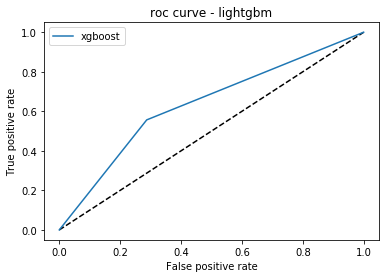

In [19]:
test_run = workflow.run(
    name = 'test_model',
    handler=test,
    inputs={'model': train_run.output('model'),
            'xtest': load_run.output('xtest'),
            'ytest': load_run.output('ytest')},
    params={'model_target': '/User/projects/lightgbm/models',
            'model_name': 'lightgbm.model.pickle'})

# Create an Image

Once debugged you can create a reusable image, and then deploy it for testing.

In [20]:
lgbm_job = code_to_function(runtime='job').apply(mount_v3io())
# # prepare an image from the dependencies, so we wont need to build the image every run 
lgbm_job.build(image='mlrun/mlrunlgb:latest')

[mlrun] 2019-12-15 12:08:31,686 building image (mlrun/mlrunlgb:latest)
FROM python:3.6-jessie
WORKDIR /run
RUN pip install -U matplotlib sklearn lightgbm kfp joblib pyarrow
RUN pip install mlrun
ENV PYTHONPATH /run
[mlrun] 2019-12-15 12:08:31,689 using in-cluster config.
[mlrun] 2019-12-15 12:08:31,707 Pod mlrun-build-4cnjc created
..
INFO[0000] Resolved base name python:3.6-jessie to python:3.6-jessie 
INFO[0000] Resolved base name python:3.6-jessie to python:3.6-jessie 
INFO[0000] Downloading base image python:3.6-jessie     
INFO[0000] Error while retrieving image from cache: getting file info: stat /cache/sha256:0318d80cb241983eda20b905d77fa0bfb06e29e5aabf075c7941ea687f1c125a: no such file or directory 
INFO[0000] Downloading base image python:3.6-jessie     
INFO[0000] Built cross stage deps: map[]                
INFO[0000] Downloading base image python:3.6-jessie     
INFO[0000] Error while retrieving image from cache: getting file info: stat /cache/sha256:0318d80cb241983eda20b9

In [36]:
lgbm_job.with_code()

### Create a multi-stage KubeFlow Pipeline from our functions

Our pipeline will consist of two instead of three steps, ```load``` and ```train```.  We'll drop the ```test```
here since at the end of this deployment we can test the system with API requests.

For complete details on KubeFlow Pipelines please refer to the following docs:
1. [KubeFlow pipelines](https://www.kubeflow.org/docs/pipelines/).
2. [kfp.dsl Python package](https://kubeflow-pipelines.readthedocs.io/en/latest/source/kfp.dsl.html#module-kfp.dsl).

Please note, the model server file name in the **```new_model_server```** function call below should not have any spaces in it.**

In [37]:
import kfp
from kfp import dsl

In [42]:
@dsl.pipeline(
    name='LGBMClassifier training pipeline',
    description='Shows how to use mlrun/kfp.'
)
def lgbm_pipeline(
   learning_rate = [0.1, 0.2], num_leaves = [30, 31]
):

    load_step = lgbm_job.as_step(
            name='load_sample_preprocess_data', 
            handler='load',
            params = {
                'sample' : -2_000,
                'target': '/User/projects/lightgbm/data/raw',
                'splits': [0.9, 0.1],
                'random_state': 1},
            outputs=['xtrain', 'ytrain', 'xvalid', 'yvalid', 'xtest', 'ytest'], 
            out_path='/User/projects/lightgbm/data'
    ).apply(mount_v3io())
    
    train_step = lgbm_job.as_step(
            name='train_model', 
            handler='train',
            params = {
                'model_target': '/User/projects/lightgbm/models',
                'model_name': 'lightgbm.model.pickle'
                },
            inputs = {'xtrain': load_step.outputs['xtrain'],
                      'ytrain':load_step.outputs['ytrain'],
                      'xvalid':load_step.outputs['xvalid'],
                      'yvalid':load_step.outputs['yvalid']}, 
            outputs=['model'],
            out_path= '/User/projects/lightgbm/models'
    ).apply(mount_v3io())

    test_step = lgbm_job.as_step(
        name='test_model',
        handler='test',
        hyperparams = {
            'learning_rate': learning_rate,
            'num_leaves': num_leaves},
        selector='max.accuracy',
        inputs = {'model': train_step.outputs['model'],
                  'xtest': load_step.outputs['xtest'],
                  'ytest':load_step.outputs['ytest']}, 
        params = {
            'model_name': 'lightgbm.model.pickle'
        },
        out_path='/User/projects/lightgbm/results'
    ).apply(mount_v3io())
    
    # define a nuclio-serving function, generated from a notebook file
    srvfn = new_model_server(
        'higgs-serving', 
        model_class='LGBoostModel', 
        filename='model-server.ipynb')
    
    # deploy the model serving function with inputs from the training stage
    deploy = srvfn.with_v3io(
        'User',
        '~/'
    ).deploy_step(
        project='projects', 
        models={'lgbm_v4_joblib': train_step.outputs['model']})

### compile the pipeline

As an optional step, we can compile our KubeFlow pipeline and produce a yaml description of the  pipeline worflow:

In [39]:
kfp.compiler.Compiler().compile(lgbm_pipeline, 'mlrunpipe.yaml')

In [40]:
client = kfp.Client(namespace='default-tenant')

In [43]:
arguments = {
    'learning_rate': [0.10, 0.30],
    'num_leaves': [27, 29]}

run_result = client.create_run_from_pipeline_func(
    lgbm_pipeline, 
    arguments, 
    run_name='lgbm 5',
    experiment_name='lgbm_parquet')

In [41]:
from mlrun import get_run_db
db = get_run_db().connect()

In [ ]:
# db.list_runs('', labels=f'workflow={run_result.run_id}').show()